In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('../names.txt', 'r') as file:
    names = file.read().split()

print('Total names:', len(names))
print(names[:5])

Total names: 32033
['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [22]:
# Form stoi and itos
vocab = sorted(list(set(''.join(names))))
stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi['.'] = 0
itos = {stoi[s]: s for s in stoi}

vocab_size = len(stoi)

In [6]:
block_size = 3

In [ ]:
def form_dataset(words):
    X = []
    Y = []

    for word in words:
        word = ['.'] * block_size + list(word) + ['.']
        for ind in range(3, len(word)):
            X.append([stoi[x] for x in word[ind-3:ind]])
            Y.append(stoi[word[ind]])
            # print(''.join(word[ind-3:ind]), '--->', word[ind])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

### Form dataset
Divide into 3: usual splits are 80, 10, 10

In [64]:
import random
random.seed(42)
random.shuffle(names)

X, Y = form_dataset(names)

n1 = int(0.8 * X.shape[0])
n2 = int(0.9 * X.shape[0])
Xtr, Xdev, Xts = X.tensor_split((n1, n2), dim=0) # input is split into X[:n1], X[n1:n2] and X[n2:]
Ytr, Ydev, Yts = Y.tensor_split((n1, n2), dim=0)
print(Ytr.shape, Ydev.shape, Yts.shape)

torch.Size([182516]) torch.Size([22815]) torch.Size([22815])


### Embedding data

In [139]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn(block_size * n_embd, n_hidden, generator=g) * 0.2
b1 = torch.randn(n_hidden,                      generator=g) * 0.01

W2 = torch.randn(n_hidden, vocab_size,          generator=g) * 0.1 # Output of emb @ W1 + b1 will feed into W2 for multiplication
b2 = torch.randn(vocab_size,                    generator=g) * 0

In [140]:
parameters = [C, W1, b1, W2, b2]
total_params = 0
for p in parameters:
    total_params += p.nelement()
    p.requires_grad = True

lossi = []

In [136]:
# 27 characters. If equally distributed, anyone of them could be equally likely. But in settings, we started with ~25 loss value. 
expected_loss = -torch.log(torch.tensor(1/27.0))
expected_loss.item()

3.295836925506592

In [147]:
batch_size = 32 # Take 32 training data points for each loop of gradient descend

for _ in range(30000):
    batch_inds = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,))
    Xb, Yb = Xtr[batch_inds], Ytr[batch_inds]
    
    embs = C[Xb]
    embcat = embs.view(-1, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    lossi.append(loss.item())

    for p in parameters:
        p.grad = None
    
    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

1.9387402534484863


In [ ]:
# Calculating for single data point
print(logits[0])
counts = logits[0].exp()

probs = counts / counts.sum()
print(probs)
print(Yb[0], probs[Yb[0]]) # After first iteraction calculated probability of expected character is really really low. Hence, high value of loss

# counts & probability should be uniform - not too high or too low
# Look at exp(x) graph

# Maybe because logits are too extreme. We need to bring them closer to 0


tensor([-5.1645e+00,  6.7292e+00, -7.7360e+00, -4.5367e+00,  7.3821e+00,
        -7.2530e+00, -4.6669e-03,  1.4076e+01,  8.8377e+00, -2.7592e-02,
         2.1454e+00, -1.7580e+01,  4.9402e+00, -5.1021e-01,  8.0447e+00,
         1.7807e+01, -7.6275e+00, -2.9075e+00, -5.5254e+00, -4.4312e+00,
         3.4334e+00,  2.8521e+01,  6.0535e+00, -2.9288e+01, -4.3446e+00,
        -5.9654e+00, -7.6684e+00], grad_fn=<SelectBackward0>)
tensor([2.3472e-15, 3.4351e-10, 1.7937e-16, 4.3973e-15, 6.5988e-10, 2.9075e-16,
        4.0874e-13, 5.3258e-07, 2.8291e-09, 3.9947e-13, 3.5090e-12, 9.5165e-21,
        5.7410e-11, 2.4654e-13, 1.2800e-09, 2.2225e-05, 1.9994e-16, 2.2426e-14,
        1.6361e-15, 4.8867e-15, 1.2723e-11, 9.9998e-01, 1.7478e-10, 7.8286e-26,
        5.3288e-15, 1.0537e-15, 1.9192e-16], grad_fn=<DivBackward0>)
tensor(18) tensor(1.6361e-15, grad_fn=<SelectBackward0>)


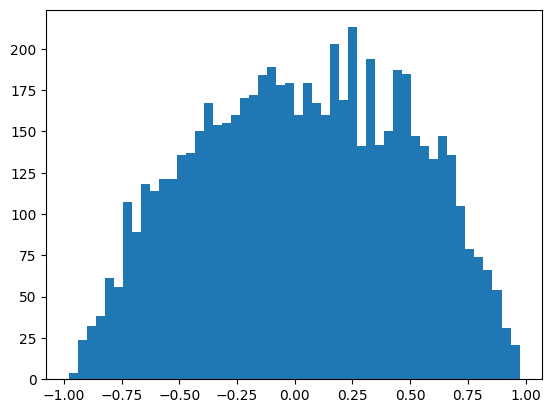

In [138]:
plt.hist(h.view(-1).tolist(), 50);

In [126]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
counts = logits.exp()
probs = counts / counts.sum()
counts
probs

tensor([0.2500, 0.2500, 0.2500, 0.2500])

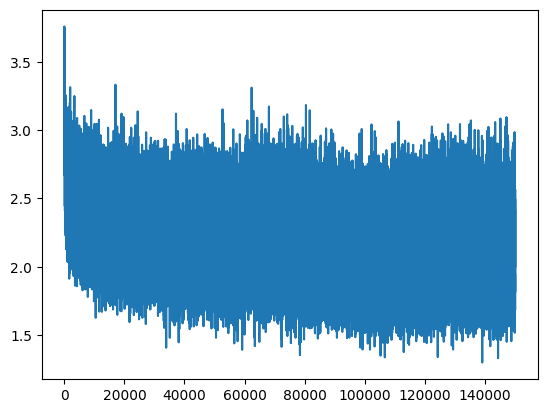

In [148]:
plt.plot(lossi)

Basic settings with loss values: 0.1, 0.01 & 0.05 and over 10K+ iterations
loss = 2.078784942626953 


In [ ]:
@torch.no_grad() # This disables gradient tracking which is required for back-propagation
def split_loss(X, Y):
    embs = C[X]
    embs = embs.view(-1, n_embd * block_size)
    print(embs.shape, W1.shape)
    h = torch.tanh(embs @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

In [159]:
print('Dev loss:', split_loss(Xdev, Ydev))
print('Test loss:', split_loss(Xts, Yts))

torch.Size([22815, 30]) torch.Size([30, 200])
Dev loss: 2.2250969409942627
torch.Size([22815, 30]) torch.Size([30, 200])
Test loss: 2.2232859134674072
